# Xopt Parallel Examples

Xopt provides methods to parallelize optimizations using Processes, Threads, MPI, and Dask using the `concurrent.futures` interface as defined in  https://www.python.org/dev/peps/pep-3148/ .

In [1]:
from xopt import AsynchronousXopt as Xopt

In [2]:
# Helpers for this notebook
import multiprocessing
N_CPUS=multiprocessing.cpu_count()
N_CPUS

import os

# directory for data. 
os.makedirs("temp", exist_ok=True)

# Notebook printing output
#from xopt import output_notebook
#output_notebook()

# Nicer plotting
%config InlineBackend.figure_format = 'retina'


The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [3]:
# Make a proper input file.
YAML = """

max_evaluations: 1000

generator:
  name: cnsga
  output_path: temp
  population_size:  64
  
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    sleep: 0
    random_sleep: 0.1
  
vocs:
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  constants: {a: dummy_constant}

"""
X = Xopt(YAML)
X


            Xopt
________________________________
Version: 0+untagged.1.ga84bd29
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0.1
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  crossover_probability: 0.9
  mutation_probability: 1.0
  name: cnsga
  output_path: temp
  population: null
  population_file: null
  population_size: 64
  supports_multi_objective: true
is_done: false
max_evaluations: 1000
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants:
    a: dummy_constant
  constraints:
    c1:
    - GREATER_THAN
    - 0.0
    c2:
    - LESS_THAN
    - 0.5
  objectives:
    y1: MINIMIZE
    y2: MINIMIZE
  observables: []
  variables:
    x1:
    - 0.0
    - 3.14159
    x2:
    - 0.0
    - 3.14159


In [4]:
%%timeit
# Check that the average time is close to random_sleep
X.evaluator.function({"x1": 0.5, "x2": 0.5}, random_sleep = .1)

92.6 ms ± 16.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%%time
X.run()

CPU times: user 6.37 s, sys: 41.2 ms, total: 6.41 s
Wall time: 1min 48s


# Processes

In [6]:
from concurrent.futures import ProcessPoolExecutor

In [7]:
%%time
X = Xopt(YAML)

with ProcessPoolExecutor(max_workers=N_CPUS) as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = N_CPUS
    X.run()
len(X.data)

CPU times: user 1min 6s, sys: 2.44 s, total: 1min 8s
Wall time: 1min 57s


1000

# Threads

Continue running, this time with threads.

In [8]:
from concurrent.futures import ThreadPoolExecutor

In [9]:
%%time
X = Xopt(YAML)

with ThreadPoolExecutor(max_workers=N_CPUS) as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = N_CPUS
    X.run()
len(X.data)

CPU times: user 6.21 s, sys: 86.8 ms, total: 6.3 s
Wall time: 52.5 s


1000

# MPI 

The `test.yaml` file completely defines the problem. We will also direct the logging to an `xopt.log` file. The following invocation recruits 4 MPI workers to solve this problem.

We can also continue by calling `.save` with a JSON filename. This will write all of previous results into the file.

In [10]:
X = Xopt(YAML)
X.dump('test.yaml') # Write this input to file
!cat test.yaml

data: null
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0.1
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  crossover_probability: 0.9
  mutation_probability: 1.0
  name: cnsga
  output_path: temp
  population: null
  population_file: null
  population_size: 64
  supports_multi_objective: true
is_done: false
max_evaluations: 1000
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants:
    a: dummy_constant
  constraints:
    c1:
    - GREATER_THAN
    - 0.0
    c2:
    - LESS_THAN
    - 0.5
  objectives:
    y1: MINIMIZE
    y2: MINIMIZE
  observables: []
  variables:
    x1:
    - 0.0
    - 3.14159
    x2:
    - 0.0
    - 3.14159


In [11]:
%%time
!mpirun -n 8 python -m mpi4py.futures -m xopt.mpi.run -vv --logfile xopt.log test.yaml

Namespace(input_file='test.yaml', logfile='xopt.log', verbose=2, asynchronous=True)
Parallel execution with 8 workers
Enabling async mode
Initialized generator cnsga
Created toolbox with 2 variables, 2 constraints, and 2 objectives.
    Using selection algorithm: nsga2

            Xopt
________________________________
Version: 0+untagged.1.ga84bd29
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0.1
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  crossover_probability: 0.9
  mutation_probability: 1.0
  name: cnsga
  output_path: temp
  population: null
  population_file: null
  population_size: 64
  supports_multi_objective: true
is_done: false
max_evaluations: 1000
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants:
    a: dummy_constant
  constraints:
    c1:
    - GREATER_THAN
    - 0.0
    c2:
    - LESS_THAN
   

In [12]:
!tail xopt.log

2023-11-08T17:17:24+0000 - xopt - INFO - Parallel execution with 8 workers
2023-11-08T17:17:24+0000 - xopt - INFO - Enabling async mode
2023-11-08T17:17:24+0000 - xopt.generator - INFO - Initialized generator cnsga
2023-11-08T17:17:24+0000 - xopt.generators.ga.cnsga - INFO - Created toolbox with 2 variables, 2 constraints, and 2 objectives.
2023-11-08T17:17:24+0000 - xopt.generators.ga.cnsga - INFO -     Using selection algorithm: nsga2
2023-11-08T17:18:00+0000 - xopt.base - INFO - Xopt is done. Max evaluations 1000 reached.


# Dask



In [13]:
from dask.distributed import Client
client = Client()
executor = client.get_executor()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 6.76 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41495,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 6.76 GiB
Comm: tcp://127.0.0.1:45889,Total threads: 1
Dashboard: http://127.0.0.1:33999/status,Memory: 3.38 GiB
Nanny: tcp://127.0.0.1:37041,


In [14]:
%%time
X = Xopt(YAML)
X.evaluator.executor = executor
X.evaluator.max_workers = N_CPUS
X.run()
len(X.data)

CPU times: user 15.5 s, sys: 1.25 s, total: 16.8 s
Wall time: 1min 3s


1000

# Load output into Pandas

This algorithm writes two types of files: `gen_{i}.json` with all of the new individuals evaluated in a generation, and `pop_{i}.json` with the latest best population. Xopt provides some functions to load these easily into a Pandas dataframe for further analysis.

In [15]:
import pandas as pd

In [16]:
X.data

,x1,x2,y1,y2,c1,c2,xopt_runtime,xopt_error
2,2.601839,0.415132,2.601839,0.415132,6.023863,4.424932,0.049044,False
1,2.994896,2.307353,2.994896,2.307353,13.340554,9.491030,0.179199,False
2,0.241867,2.185775,0.241867,2.185775,3.855246,2.908471,0.014085,False
3,0.160144,0.912346,0.160144,0.912346,-0.048440,0.285531,0.043002,False
4,1.776579,2.533208,1.776579,2.533208,8.666929,5.763587,0.145748,False
...,...,...,...,...,...,...,...,...
995,0.241251,0.904208,0.241251,0.904208,-0.072738,0.230335,0.191538,False
996,0.666334,0.102616,0.666334,0.102616,-0.468778,0.185581,0.111264,False
997,0.222266,0.967880,0.222266,0.967880,0.075348,0.296048,0.145978,False
998,0.472966,0.929141,0.472966,0.929141,0.055507,0.184892,0.089231,False


In [17]:
df = pd.concat([X.data, X.vocs.feasibility_data(X.data)], axis=1)
df[df['feasible']]

,x1,x2,y1,y2,c1,c2,xopt_runtime,xopt_error,feasible_c1,feasible_c2,feasible
55,0.910120,0.877360,0.910120,0.877360,0.502346,0.310599,0.187057,False,True,True,True
97,1.159755,0.342483,1.159755,0.342483,0.474106,0.460089,0.015861,False,True,True,True
128,0.125202,1.093934,0.125202,1.093934,0.237348,0.493230,0.179181,False,True,True,True
217,0.996778,0.401850,0.996778,0.401850,0.056198,0.256422,0.099972,False,True,True,True
255,0.910120,0.917614,0.910120,0.917614,0.570548,0.342599,0.060793,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
992,0.480863,0.933602,0.480863,0.933602,0.078685,0.188377,0.142936,False,True,True,True
993,0.078512,1.031206,0.078512,1.031206,0.034795,0.459832,0.168401,False,True,True,True
997,0.222266,0.967880,0.222266,0.967880,0.075348,0.296048,0.145978,False,True,True,True
998,0.472966,0.929141,0.472966,0.929141,0.055507,0.184892,0.089231,False,True,True,True


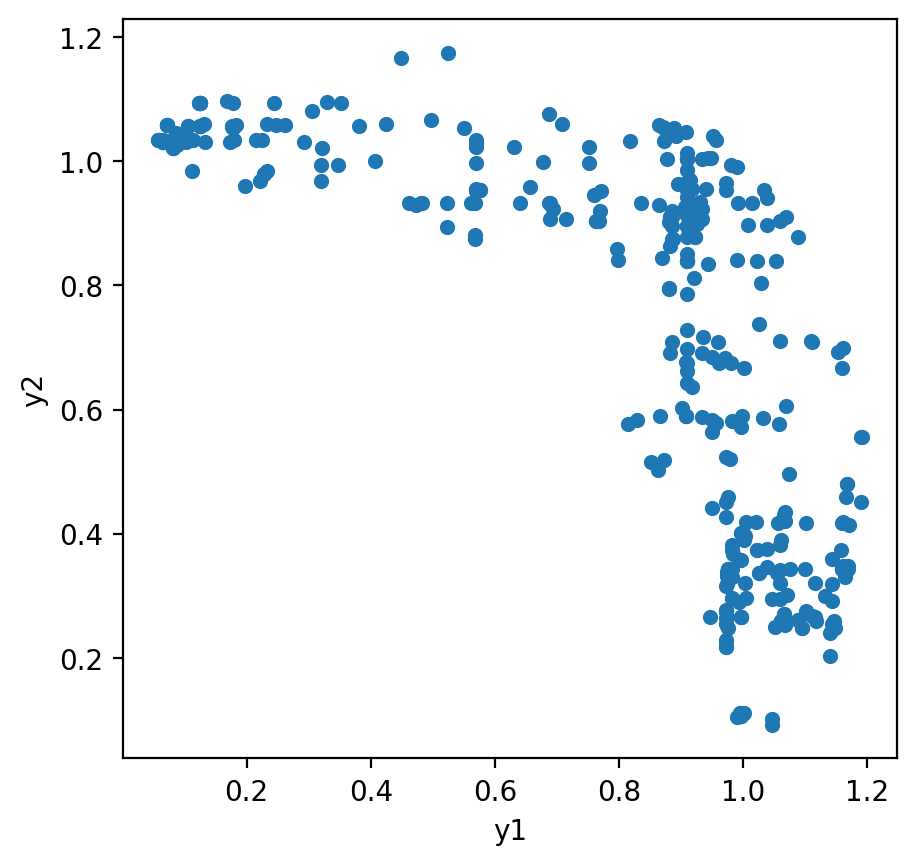

In [18]:
# Plot the feasible ones
feasible_df = df[df["feasible"]]
feasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

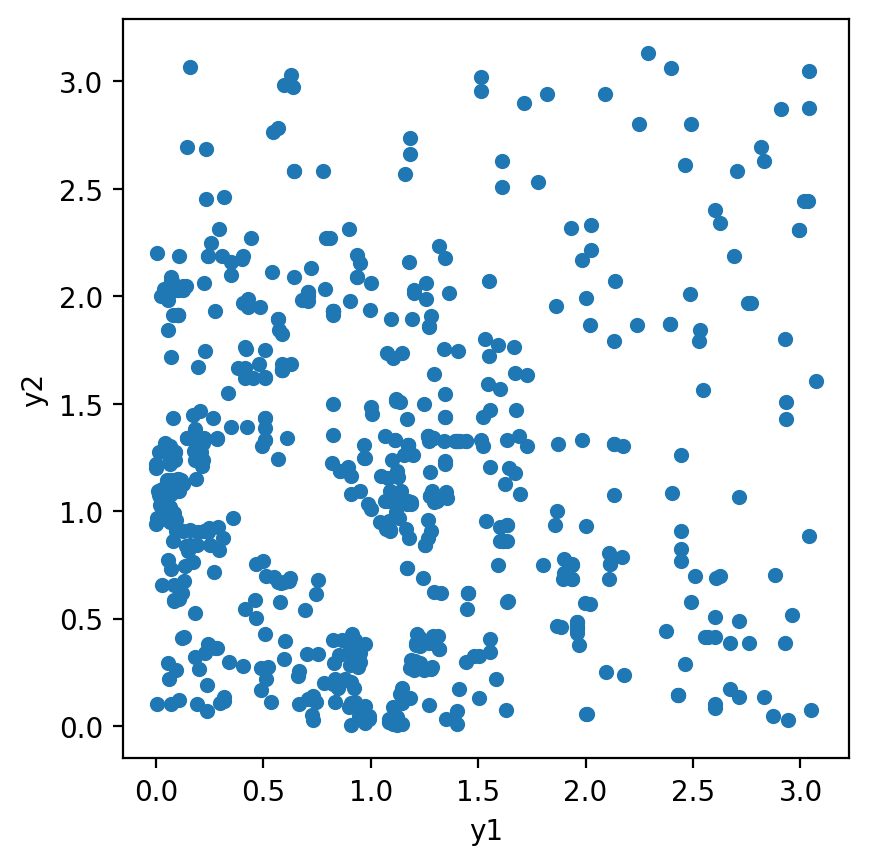

In [19]:
# Plot the infeasible ones
infeasible_df = df[~df["feasible"]]
infeasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

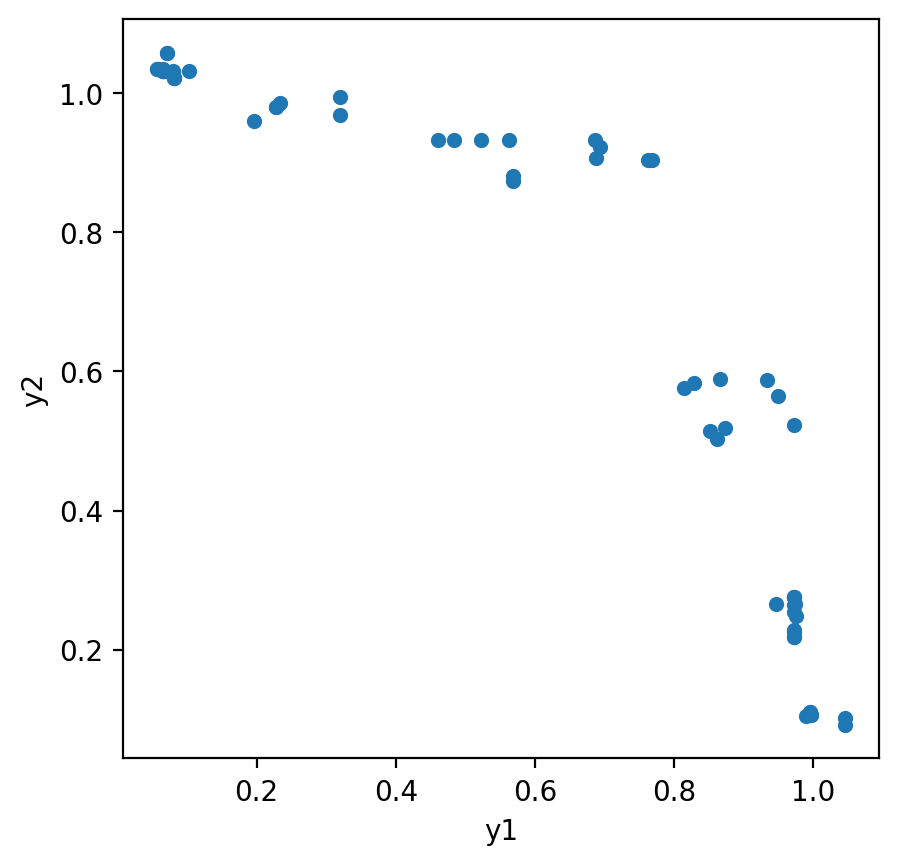

In [20]:
# This is the final population
df1 = X.generator.population
df1.plot("y1", "y2", kind="scatter").set_aspect("equal")

# matplotlib plotting

You can always use matplotlib for customizable plotting

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline

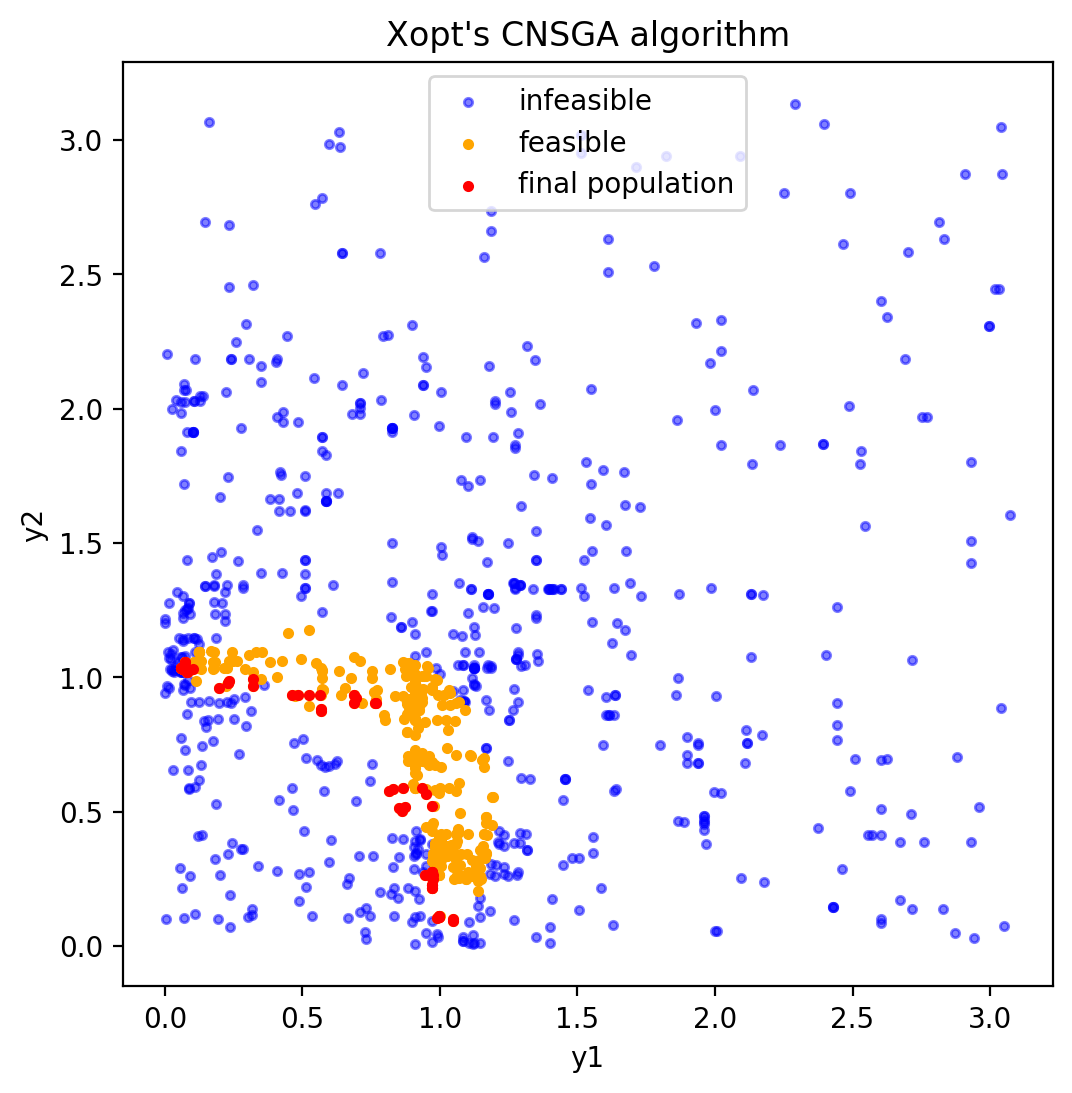

In [22]:
# Extract objectives from output
k1, k2 = "y1", "y2"

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    infeasible_df[k1],
    infeasible_df[k2],
    color="blue",
    marker=".",
    alpha=0.5,
    label="infeasible",
)
ax.scatter(
    feasible_df[k1], feasible_df[k2], color="orange", marker=".", label="feasible"
)
ax.scatter(df1[k1], df1[k2], color="red", marker=".", label="final population")
ax.set_xlabel(k1)
ax.set_ylabel(k2)
ax.set_aspect("auto")
ax.set_title(f"Xopt's CNSGA algorithm")
plt.legend()

In [23]:
# Cleanup
#!rm -r dask-worker-space
!rm -r temp
!rm xopt.log*
!rm test.yaml